# Tensorflow Tutorial 1: Simple Logistic Classification on MNIST

初次學習Tensorflow最困難的地方莫過於不知道從何下手，已經學會很多的Deep Learning理論，但是要自己使用Tensorflow將Network建起來卻是非常困難的，這篇文章我試著去建立一個最簡單的分類模型，從模型的建立過程一邊學習Tensorflow如何運作。

## MNIST Dataset

首先，先`import`一些會用到的function，並且定義`summary` function以便於觀察ndarray。

In [42]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

def summary(ndarr):
    print(ndarr)
    print("* shape: {}".format(ndarr.shape))
    print("* min: {}".format(np.min(ndarr)))
    print("* max: {}".format(np.max(ndarr)))
    print("* avg: {}".format(np.mean(ndarr)))
    print("* std: {}".format(np.std(ndarr)))
    print("* unique: {}".format(np.unique(ndarr)))

ndarray是numpy的基本元素，它非常便於我們做矩陣的運算。

接下來下載MNIST Dataset當作我們練習的標的，在Tensorflow你可以很簡單的得到「處理過後的」MNIST，MNIST包含一堆手寫數字的圖片，每張圖片大小為28x28，每一張圖片都是一個手寫的阿拉伯數字包含0到9，並且標上它所對應的數字。我們的目標就是要利用MNIST做到手寫數字辨識，給出它相應的數字。

In [43]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

train_data = mnist.train
valid_data = mnist.validation
test_data = mnist.test

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


每個`train_data`、`valid_data`、`test_data`都包含兩部分：圖片和標籤。

我們來看一下圖片的部分，`train_data`一共有55000張圖，每一張圖原本大小是28x28，不過特別注意這裡的Data已經先做過預先處理了，因此圖片已經被打平成28x28=784的一維矩陣了，另外每個Pixel的值也先做過「Normalization」了，通常會這樣處理，減去128再除以128，所以你可以從`summary`中看到它的最大最小值落在0到1之間，另外這個Dataset也已經做過亂數重排了。

In [44]:
summary(train_data.images)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
* shape: (55000, 784)
* min: 0.0
* max: 1.0
* avg: 0.13070042431354523
* std: 0.30815958976745605
* unique: [ 0.          0.00392157  0.00784314  0.01176471  0.01568628  0.01960784
  0.02352941  0.02745098  0.03137255  0.03529412  0.03921569  0.04313726
  0.04705883  0.0509804   0.05490196  0.05882353  0.0627451   0.06666667
  0.07058824  0.07450981  0.07843138  0.08235294  0.08627451  0.09019608
  0.09411766  0.09803922  0.10196079  0.10588236  0.10980393  0.1137255
  0.11764707  0.12156864  0.1254902   0.12941177  0.13333334  0.13725491
  0.14117648  0.14509805  0.14901961  0.15294118  0.15686275  0.16078432
  0.16470589  0.16862746  0.17254902  0.17647059  0.18039216  0.18431373
  0.18823531  0.19215688  0.19607845  0.20000002  0.20392159  0.20784315
  0.21176472  0.21568629  0.21960786

來試著畫圖來看看，我們使用ndarray的index功能來選出第10張，`train_data.images[10,:]`表示的是選第一軸的第10個和第二軸的全部。

In [45]:
def plot_fatten_img(ndarr):
    img = ndarr.copy()
    img.shape = (28,28)
    plt.imshow(img, cmap='gray')
    plt.show()

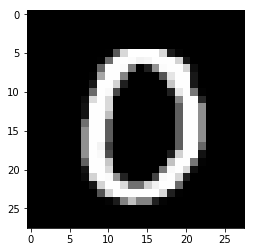

In [46]:
plot_fatten_img(train_data.images[10,:])

很顯而易見的，這是一個0。

接下來來看標籤的部分，`train_data.labels`一樣的也是有55000筆資料，所對應的就是前面的每一張圖片，總共有10種類型:0到9，所以大小為(55000, 10)。

In [47]:
summary(train_data.labels)

[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
* shape: (55000, 10)
* min: 0.0
* max: 1.0
* avg: 0.1
* std: 0.30000000000000004
* unique: [ 0.  1.]


所以我們來看看剛剛那張圖片的標籤，

In [48]:
print(train_data.labels[10])

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


看起來的確沒錯，在0的位置標示1.，而其他地方標示為0.，所以這是一個標示為0的label，這種表示方法稱為One-Hot Encoding，它有機率的涵義，因為我已經知道這個圖片是0，所以沒有疑慮100%的機會落在0的類別上。



## 分離數據的重要性

在MNIST Dataset中，你會發現分為Training Dataset、Validation Dataset和Testing Dataset，這樣的作法在Machine Learning中是常見且必要的。

流程是這樣的，我們會先使用Training Dataset來訓練Model，並且使用Validation Dataset來檢驗Model的好壞，也是調整Model上參數的依據，試著盡可能的壓低Validation Dataset的Error，記住！在過程中所產生的所有Models都要保留下來，以最後的Testing Dataset來做最後的挑選，挑選出能使Testing Dataset的Error最小的Model。

這樣的作法就是要避免Overfitting的情況發生，也就是機器可能因為看過一筆Data，結果就把這筆Data給完整記了起來，而Data本身含有雜訊，結果就因為這樣，雜訊滲透到我們的Model裡，所以我們要確實做到分離，讓Model在測試階段時可以使用沒有看過的Data。

因此，Validation Dataset的分離就是避免讓Model在Training階段看到要驗證的資料，所以更能正確的評估Model的好壞。但不幸的是，在人為調整Model的過程當中，我們會去調整參數讓Validation Dataset的Error可以降低，這樣的作法無形之中已經將Validation Dataset的資訊間接的經由人傳給了Model，所以為了避免這樣的情形，因此在最後挑選Models時，我們使用另外一筆從沒看過的資料Testing Dataset來做挑選。

## 第一個Tensorflow Model

以下我把這個Model寫成一個`class`，先瞄一眼我後續再慢慢的解釋。

In [89]:
class SimpleLogisticClassification(object):
    def __init__(self,n_features,n_labels,learning_rate=0.5):
        self.n_features = n_features
        self.n_labels = n_labels
        self.graph = tf.Graph()
        self.build(learning_rate)
        self.sess = tf.Session(graph=self.graph)
        
    def build(self,learning_rate):
        with self.graph.as_default():
            ### Input
            self.features = tf.placeholder(tf.float32, shape=(None,self.n_features))
            self.labels   = tf.placeholder(tf.int32  , shape=(None,self.n_labels))
            
            ### Computation
            self.Weights = {}
            self.Biases  = {} 
            self.Scores  = {}
            self.Xs      = {}
            
            self.Weights['fc1'], self.Biases['fc1'], self.Scores['fc1'], self.Xs['fc1'] \
                      = self.getDenseLayer(self.features, self.n_labels, activation=tf.nn.softmax)
            self.logits = self.Scores['fc1']
            self.y_ = self.Xs['fc1'] 
            
            ### Optimalization
            self.loss = tf.reduce_mean(
                            tf.nn.softmax_cross_entropy_with_logits(labels=self.labels,logits=self.logits))
            
            self.train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)
            
            ### Initialization
            self.init_op = tf.global_variables_initializer()
            
    def getDenseLayer(self,input_layer,n_output,activation=None):
        n_input = int(input_layer.shape[1])
        W = tf.Variable(
                    tf.truncated_normal( shape=(n_input,n_output) ))
        b = tf.Variable(tf.zeros( shape=(n_output) ))
        s = tf.add(tf.matmul(input_layer,W),b)
        if activation:
            x_new = activation(s)
        else:
            x_new = None
        return (W,b,s,x_new)
    
    def fit(self,X,y,epochs=10,validation_data=None,test_data=None):
        self.sess.run(self.init_op)
        for epoch in range(epochs):
            print("Epoch %2d/%2d: "%(epoch+1,epochs))
            feed_dict = {self.features: X, self.labels: y}
            _ = self.sess.run(self.train_op, feed_dict=feed_dict)
            
            y_ = self.predict(X)
            train_loss = self.evaluate(X,y)
            train_acc = self.accuracy(y_,y)
            msg = " loss = %8.4f, acc = %3.2f%%" % ( train_loss, train_acc*100 )
            
            if validation_data:
                val_loss = self.evaluate(validation_data[0],validation_data[1])
                val_acc = self.accuracy(self.predict(validation_data[0]),validation_data[1])
                msg += ", val_loss = %8.4f, val_acc = %3.2f%%" % ( val_loss, val_acc*100 )
            
            print(msg)
            
        if test_data:
            test_acc = self.accuracy(self.predict(test_data[0]),test_data[1])
            print("test_acc = %3.2f%%" % (test_acc*100))
            
    def accuracy(self, predictions, labels):
        return (np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/predictions.shape[0])
    
    def predict(self,X):
        return self.sess.run(self.y_, feed_dict={self.features: X})
    
    def evaluate(self,X,y):
        return self.sess.run(self.loss, feed_dict={self.features: X, self.labels: y})

使用物件導向的寫法，可以讓程式看起來更有條理，在這裡我就把我要訓練的Model物件化。

`SimpleLogisticClassification`包含6個部分，一開始在`def __init__(...)`中先初始化這個Model，接下來在`def __structure(...)`裡頭定義Model的結構，然後使用`def fit(...)`來做Training，而`def accuracy(...)`用來計算正確率，最後兩個函數`def predict(...)`和`def evaluate(...)`則是用來推演用的。

In [90]:
model = SimpleLogisticClassification(n_features=28*28,
                                     n_labels=10,
                                     learning_rate= 0.5,)
model.fit(X=train_data.images,
          y=train_data.labels,
          epochs=10,
          validation_data=(valid_data.images,valid_data.labels),
          test_data=(test_data.images,test_data.labels), )

Epoch  1/10: 
 loss =   9.5909, acc = 12.50%, val_loss =   9.5429, val_acc = 12.58%
Epoch  2/10: 
 loss =   8.4425, acc = 14.65%, val_loss =   8.4002, val_acc = 14.82%
Epoch  3/10: 
 loss =   7.5826, acc = 16.89%, val_loss =   7.5453, val_acc = 17.00%
Epoch  4/10: 
 loss =   6.9411, acc = 19.07%, val_loss =   6.9095, val_acc = 19.08%
Epoch  5/10: 
 loss =   6.4326, acc = 21.19%, val_loss =   6.4074, val_acc = 21.74%
Epoch  6/10: 
 loss =   6.0045, acc = 23.23%, val_loss =   5.9850, val_acc = 23.56%
Epoch  7/10: 
 loss =   5.6323, acc = 25.33%, val_loss =   5.6169, val_acc = 25.66%
Epoch  8/10: 
 loss =   5.3036, acc = 27.45%, val_loss =   5.2912, val_acc = 27.86%
Epoch  9/10: 
 loss =   5.0113, acc = 29.61%, val_loss =   5.0009, val_acc = 30.26%
Epoch 10/10: 
 loss =   4.7504, acc = 31.67%, val_loss =   4.7411, val_acc = 32.44%
test_acc = 32.00%
